# Demonstrating Using Mutual Information to Identify Nonlinear Correlations
(all referenced academic articles are in our library)

### Preamble - Imports and Function Definitions

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
from minepy import cstats, pstats, MINE
import matplotlib.pyplot as plt

import chart_studio.plotly as ply
import plotly.offline as plyoff
import plotly.graph_objects as go
import plotly.subplots as plysub

In [2]:
''' correlations plot '''
def correlationsPlot(rhoYourBoat, plotTitl='Feature Correlations Plot', trcLims=(0.0, 1.0), tweaks=(20, None, None, 1.1)):
    '''
    This creates and returns a bubble plot visualization of a correlation matrix. The
    sizes of the bubbles are proportional to the absolute magnitude of the correlations.
    Positive correlations are only plotted in the upper triangle, with colors ranging
    from green (0) to red (+1). Negative correlations are plotted in the lower triangle,
    with colors ranging from green (0) to blue (-1). Perfect correlations are indicated
    with black bubbles.
    :param rhoYourBoat: dataframe of correlation matrix, probably created with pd.DataFrame.corr()
    :param plotTitl: optional (default='Feature Correlations Plot') plot title
    :param trcLims: (default=(0.0,1.0)) = ordered tuple of "buckets" in which to place absolute correlations for
        plotting traces; must include at least 0 and 1
    :param tweaks (default=(20,None,None,1.1)): tuple of position & size tweaking values for plotly; maximum size of
        bubbles, plot width, plot height, y position of legend
    :return fig: plotly correlation plot figure
    '''

    # set the granulatrity of the colors
    n = 101  # must be odd so in the middle at correlation = 0 is just green

    # number features
    p = len(rhoYourBoat.columns)
    ps = list(range(p))

    # positive correltions are red>green
    scl = np.linspace(1.0, 0.0, n)
    redsP = np.round(255 * scl)
    grnsP = 255 - redsP
    blusP = [0.0] * n

    # negative correlations are blue>green
    scl = scl[:-1]
    blusN = np.round(255 * scl)
    grnsN = 255 - blusN
    redsN = [0.0] * n

    # adding 2 more to make the endpoints for perfect correlations
    scl = np.linspace(-1.0, 1.0, 2 * n - 1 + 2)

    # make the colormap - perfectly uncorrelated and perfectly correlated are black
    rgb = ['rgb(0,0,0)']
    rgb.extend(['rgb(%d,%d,%d)' % (r, g, b) for r, g, b in
                zip(np.r_[redsN, redsP[::-1]], np.r_[grnsN, grnsP[::-1]], np.r_[blusN, blusP[::-1]])])
    rgb.append('rgb(0,0,0)')

    # now map correlations to colors - unhappy that I have to do this double loop :-(
    vals = rhoYourBoat.values
    cols = np.zeros(shape=vals.shape, dtype=object)
    for i in ps:
        for j in ps:
            v = vals[i, j]
            mni = np.argmin(np.abs(v - scl))
            mnv = scl[mni]
            cols[i, j] = rgb[mni]
            # print('%0.5f,%d,%0.5f,%s'%(v,mni,mnv,cols[i,j]))

    # filter data so the upper triangle is (+) correlations and lower triangle is (-) correlations
    y = np.tile(ps, (p, 1))
    x = y.T
    x = x.flatten()
    y = y.flatten()
    vals = vals.flatten()
    cols = cols.flatten()
    keepind = ((y > x) & (vals > 0)) | ((x > y) & (vals < 0))
    x = x[keepind]
    y = y[keepind]
    vals = vals[keepind]
    cols = cols[keepind]
    absVals = np.abs(vals)

    # set a minimum bubble size
    minBub = 0.09 * tweaks[0]

    # put together the figure - make multiple traces
    trc = [go.Scatter(
        {'x': ps, 'y': ps, 'mode': 'lines', 'line': {'color': 'black'}, 'showlegend': False, 'hoverinfo': 'skip'})]
    for i, t in enumerate(trcLims):
        # build the index for the traces
        if i == 0:
            continue
        elif i == 1:
            indx = (absVals <= t) & (absVals >= trcLims[0])
            trcName = '$\\vert\\rho\\vert\\in[%0.2f,%0.2f]$' % (trcLims[0], t)
        else:
            indx = (absVals <= t) & (absVals > trcLims[i - 1])
            trcName = '$\\vert\\rho\\vert\\in(%0.2f,%0.2f]$' % (trcLims[i - 1], t)
        # create & add the trace
        trc.append(go.Scatter({'x': x[indx], 'y': y[indx], 'mode': 'markers', 'text': ['%0.4f' % v for v in vals[indx]],
                               'name': trcName, 'hoverinfo': 'x+y+text',
                               'marker': {'color': cols[indx], 'line': {'color': cols[indx]},
                                          'size': np.maximum(tweaks[0] * absVals[indx], minBub)}}))

    # finalize the layout
    lout = go.Layout({'title': plotTitl, 'legend': {'orientation': 'h', 'x': 0, 'y': tweaks[-1]},
                      'xaxis': {'ticklen': 1, 'tickvals': ps, 'ticktext': rhoYourBoat.columns.values,
                                'mirror': True, 'showgrid': False, 'range': [-1, p], 'linecolor': 'black',
                                'linewidth': 0.5, 'zeroline': False, 'tickangle': 90},
                      'yaxis': {'ticklen': 1, 'tickvals': ps, 'ticktext': rhoYourBoat.index.values,
                                'mirror': True, 'showgrid': False, 'range': [-1, p], 'linecolor': 'black',
                                'linewidth': 0.5, 'zeroline': False}})
    if tweaks[1] is not None:
        lout['width'] = tweaks[1]
    if tweaks[2] is not None:
        lout['height'] = tweaks[2]

    return go.Figure(data=trc, layout=lout)

In [3]:
''' nonlinear correlations plot '''
def nonlinearCorrelationsPlot(data:pd.DataFrame, mineMethod:str='mic_e',
                              mineCrit:str='TIC', plotParams:dict=None):
    '''
    Compute and maybe plot pairwise nonlinear correlations using mutual information
    according to this article: https://www.science.org/doi/10.1126/science.1205438.
    The article is in our library. If desired, a correlations plot can be generated.
    :param data: dataframe of data for pairwise correlation computation
    :param mineMethod: optional (default='mic_e') method for MINE; either
        'mic_e', or 'mic_approx'
    :param mineCrit: optional (default='TIC') MINE criteria to use; either 'MIC'
        or 'TIC'
    :param plotParams: optional (default=None) dict of correlationsPlot parameters
        with keys 'plotTitl', 'trcLims', 'tweaks'
    :return MI: dataframe of pairwise MINE stats as desired; only the upper
        triangle has data (column > index)
    :return fig: if plotParams is not None, this is the correlations plot using
        the MINE statistics; otherwise is just None
    '''

    # compute the mutual information values
    MICTIC = pstats(X=data.values.T, est=mineMethod)
    # get the criteria of interest, either MIC or TIC
    MI = MICTIC[mineCrit=='TIC']

    # build the square matrix a-la a correlations matrix
    p = len(data.columns)
    matrixMI = np.eye(p)
    # fill in the upper triangle (mutual information can't be negative)
    rowInd, colInd = np.triu_indices(n=p, k=1)
    for (row, col, mi) in zip(rowInd, colInd, MI):
        matrixMI[row, col] = mi
    # finally, make a dataframe of it
    matrixMI = pd.DataFrame(index=data.columns, data=matrixMI, columns=data.columns)

    # plot if desired
    if plotParams is not None:
        fig = correlationsPlot(matrixMI, **plotParams)
    else:
        fig=None

    return matrixMI, fig

## Prepare the Data

In [4]:
''' Make data that is clearly related, though not (mostly) linearly '''
# make data - pretend X is a response and all others are features
n = 100
center = n/2
radius = 50
data = pd.DataFrame(data=np.linspace(1, n, n), columns=['X'])
data['sin'] = np.sin(data['X']/20)
data['semi'] = np.sqrt(radius**2 - (data['X']-center)**2) + center
data['inv'] = 1/data['X']
data['relu'] = np.where(data['X']<center, 1, data['X'])
data['invlog'] = 1/np.log(data['X'])
data['hinge'] = np.where(data['X']<center, data['X'], n-data['X'])

# talk
print('Sample Data')
display(data.head(10))

# plot sample data
trcs = [None]*len(data.columns)
for (indx, col) in enumerate(data.columns):
    trcs[indx] = go.Scatter(x=data['X'], y=data[col], name=col)
figData = go.Figure(data=trcs, layout=go.Layout(title='Sample Data'))
plyoff.iplot(figData)

Sample Data


,X,sin,semi,inv,relu,invlog,hinge
0,1.0,0.049979,59.949874,1.000000,1.0,inf,1.0
1,2.0,0.099833,64.000000,0.500000,1.0,1.442695,2.0
2,3.0,0.149438,67.058722,0.333333,1.0,0.910239,3.0
3,4.0,0.198669,69.595918,0.250000,1.0,0.721348,4.0
4,5.0,0.247404,71.794495,0.200000,1.0,0.621335,5.0
5,6.0,0.295520,73.748684,0.166667,1.0,0.558111,6.0
6,7.0,0.342898,75.514702,0.142857,1.0,0.513898,7.0
7,8.0,0.389418,77.129320,0.125000,1.0,0.480898,8.0
8,9.0,0.434966,78.618176,0.111111,1.0,0.455120,9.0
9,10.0,0.479426,80.000000,0.100000,1.0,0.434294,10.0


In [32]:
# compute and plot the pairwise linear correlations
corr = data.corr()
figLin = correlationsPlot(corr, plotTitl='Linear Correlations',
    trcLims=[0.0, 0.5, 0.75, 0.9, 1.0])
plyoff.iplot(figLin)

Observe how few of the relationships - especially with `X` are captured as high, since they are nonlinear.

## Explore MINE to Identify Nonlinear Correlations
I have been interested in the entropic idea of information since reading <a href="https://en.wikipedia.org/wiki/Claude_Shannon">Claude Shannon's</a> ground-breaking 1948 paper <a href="https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf">A Mathematical Theory of Communication</a> and subsequent book.

For example, <a href="https://github.com/ahowe42/QuantExplNotebooks/blob/master/src/GTDWFE.ipynb">this notebook</a> in my <a href="https://github.com/ahowe42/QuantExplNotebooks/tree/master">Quantitative Exploration Github repository</a> explores using the technique described in <a href="https://www.nature.com/articles/s41598-019-50686-z">Antimicrobial Resistance Prediction for Gram-Negative Bacteria via Game Theory-Based Feature Evaluation</a> to perform feature selection. This technique is based on <a href="https://en.wikipedia.org/wiki/Mutual_information">mutual information</a> and <a href="https://en.wikipedia.org/wiki/Conditional_mutual_information">conditional mutual information</a> to parsimoniously identify features to use in ML modeling. Chowdery *et al.* applied their technique for classification modeling, and I attempted to extend it to regression modeling. Their code is in <a href="https://github.com/abu034004/GTDWFE/blob/master/code/GT_Feature_Selection.R">R</a>, and we should all know by now that "friends don't let friends use R".

I recently read the paper <a href="https://www.science.org/doi/10.1126/science.1205438">Detecting Novel Associations in Large Dataset</a>, and it seemed like another useful technique for feature selection for regression modeling. This article introduced the `maximal information coefficient` (MIC) to measure dependence between variables. In short, the algorithm for computing MIC between variables $X_1$ and $X_2$ is
1. buid the scatter plot of $X_1$ and $X_2$
2. overlay a series of grids, up to a specified maximum resolution
3. compute the maximum (over grid cells) mutual information for each grid
4. normalize to $\left[0, 1\right]$

MIC has the following *equitability* properties
- assigns a perfect score of 1 to all never-constant noiseless functional relationships
- assigns scores that tend to 1 for a larger class of noiseless relationships (including superpositions of noiseless functional relationships)
- assigns a score of 0 to statistically independent variables
- is bounded from below by a function of $R^2$ for a noisy functional relationship

Reshef *et al.* futher introduced the `total information coefficient` (TIC) in <a href="https://jmlr.csail.mit.edu/papers/volume17/15-308/15-308.pdf">Measuring Dependence Powerfully and Equitably</a> which trades some equitability for power.

While Reshef *et al.*'s algorithm for computing MIC / TIC is not explained in sufficient detail to implement myself (specifically around the gridding), there is a python implementation named <a href="https://minepy.readthedocs.io/en/latest/python.html">minepy</a> (`pip install minepy`). This package can compute MIC and TIC using two version: `mix_approx` (original) and `mic_e` (more efficient, I think).

In [6]:
''' compute and plot MI correlations betweeen (supposed) features & responses '''
# compute the mutual information correlations
method = 'mic_e' # get MIC and TIC
cols = data.columns[1:]
(MIC, TIC) = cstats(X=data[cols].values.T,
                    Y=np.atleast_2d(data['X'].values), est=method)
# plot
figBar = plysub.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles=['MIC', 'TIC'])
figBar.add_trace(go.Bar(x=cols, y=MIC.squeeze(), name='MIC',
    text=['%0.2f'%v for v in MIC], textposition='inside'), 1, 1)
figBar.add_trace(go.Bar(x=cols, y=TIC.squeeze(), name='TIC',
    text=['%0.2f'%v for v in TIC], textposition='inside'), 1, 2)
figBar.update_layout({'title':'Nonlinear Correlations against X', 'showlegend':False})
plyoff.iplot(figBar)

Note that the TIC correlations are all less than their respective MIC values. This comes from the tradeoff of equitability for power.

In [33]:
# compute and plot the pairwise nonlinear correlations '''
method = 'mic_e'
criteria = 'TIC'
pltTit = 'Nonlinear MI Correlations (%s-%s)'%(method, criteria)
MICorrelations, figNon = nonlinearCorrelationsPlot(data, method, criteria,
                                                   plotParams={'plotTitl':pltTit,
                                                   'trcLims':[0.0, 0.5, 0.75, 0.9, 1.0]})
plyoff.iplot(figNon)

Reviewing the MIC correlations, note how most are relatively large, indicating substantial dependence as measured by the mutual informations. Most are larger than their respective $R^2$ values.

## Put it all Together

In [34]:
# put the plots together
specs = [[{'colspan': 2}, None], [{}, {}]]
allFigs = plysub.make_subplots(rows=2, cols=2, print_grid=False, specs=specs,
    subplot_titles=[figData.layout['title']['text'], figLin.layout['title']['text'],
    figNon.layout['title']['text']])
# add the sample data plot
for trc in figData.data:
    allFigs.add_trace(trc, 1, 1)
# add the correlations plots
for trc in figLin.data:
    trc['showlegend']=False
    allFigs.add_trace(trc, 2, 1)
allFigs.layout['xaxis2']['tickvals'] = figLin['layout']['xaxis']['tickvals']
allFigs.layout['yaxis2']['tickvals'] = figLin['layout']['yaxis']['tickvals']
allFigs.layout['xaxis2']['ticktext'] = figLin['layout']['xaxis']['ticktext']
allFigs.layout['yaxis2']['ticktext'] = figLin['layout']['yaxis']['ticktext']
for trc in figNon.data:
    trc['showlegend']=False
    allFigs.add_trace(trc, 2, 2)
allFigs.layout['xaxis3']['tickvals'] = figNon['layout']['xaxis']['tickvals']
allFigs.layout['yaxis3']['tickvals'] = figNon['layout']['yaxis']['tickvals']
allFigs.layout['xaxis3']['ticktext'] = figNon['layout']['xaxis']['ticktext']
allFigs.layout['yaxis3']['ticktext'] = figNon['layout']['yaxis']['ticktext']
# finish with the plot
allFigs.layout.update({'title':'Demonstrating Nonlinear Correlations', 'height':800})

# show the plot
plyoff.iplot(allFigs)

In [31]:
''' show correlations & differences '''
# prep
absCorr = pd.DataFrame(index=data.columns, data=np.triu(data.corr().abs().values),
                       columns=data.columns).replace({0.0:np.nan, 1.0:np.nan})
MICorrelations = MICorrelations.replace({0.0:np.nan, 1.0:np.nan})
diff = MICorrelations - absCorr
diff[diff<0] = np.nan

# highlight "big" differences
bg = lambda x: 'background-color : blue' if x>0.4 else ''
bgDiff = lambda x: diff.applymap(bg)

# talk
print('Nonlinear > Absolute Linear')
display(diff.style.applymap(bg))
print('Linear Correlations (Absolute)')
display(absCorr.style.apply(bgDiff, axis=None))
print(pltTit)
display(MICorrelations.style.apply(bgDiff, axis=None))


Nonlinear > Absolute Linear


,X,sin,semi,inv,relu,invlog,hinge
X,nan,0.015996,0.542698,0.493907,0.023297,0.358599,0.572853
sin,nan,nan,nan,0.758915,nan,0.628729,nan
semi,nan,nan,nan,0.151495,0.198757,0.206300,0.057761
inv,nan,nan,nan,nan,0.631388,nan,0.232757
relu,nan,nan,nan,nan,nan,0.516381,0.188040
invlog,nan,nan,nan,nan,nan,nan,0.236034
hinge,nan,nan,nan,nan,nan,nan,nan


Linear Correlations (Absolute)


,X,sin,semi,inv,relu,invlog,hinge
X,nan,0.821564,0.060144,0.480085,0.932460,0.615393,0.029990
sin,nan,nan,0.486490,0.095846,0.916998,0.226031,0.499524
semi,nan,nan,nan,0.462194,0.210702,0.407389,0.916627
inv,nan,nan,nan,nan,0.323681,0.995005,0.360680
relu,nan,nan,nan,nan,nan,0.452891,0.198990
invlog,nan,nan,nan,nan,nan,nan,0.357403
hinge,nan,nan,nan,nan,nan,nan,nan


Nonlinear MI Correlations (mic_e-TIC)


,X,sin,semi,inv,relu,invlog,hinge
X,nan,0.837559,0.602843,0.973992,0.955757,0.973992,0.602843
sin,nan,nan,0.381212,0.854760,0.852524,0.854760,0.381212
semi,nan,nan,nan,0.613689,0.409460,0.613689,0.974389
inv,nan,nan,nan,nan,0.955069,0.973992,0.593436
relu,nan,nan,nan,nan,nan,0.969272,0.387030
invlog,nan,nan,nan,nan,nan,nan,0.593436
hinge,nan,nan,nan,nan,nan,nan,nan


## Interesting Example from minepy
code copied from <a href="https://minepy.readthedocs.io/en/latest/python.html">here</a>

C:\Users\i25169\AppData\Local\Temp\ipykernel_17192\2876657363.py:59: DeprecationWarning:

This function is deprecated. Please call randint(0, 1 + 1) instead



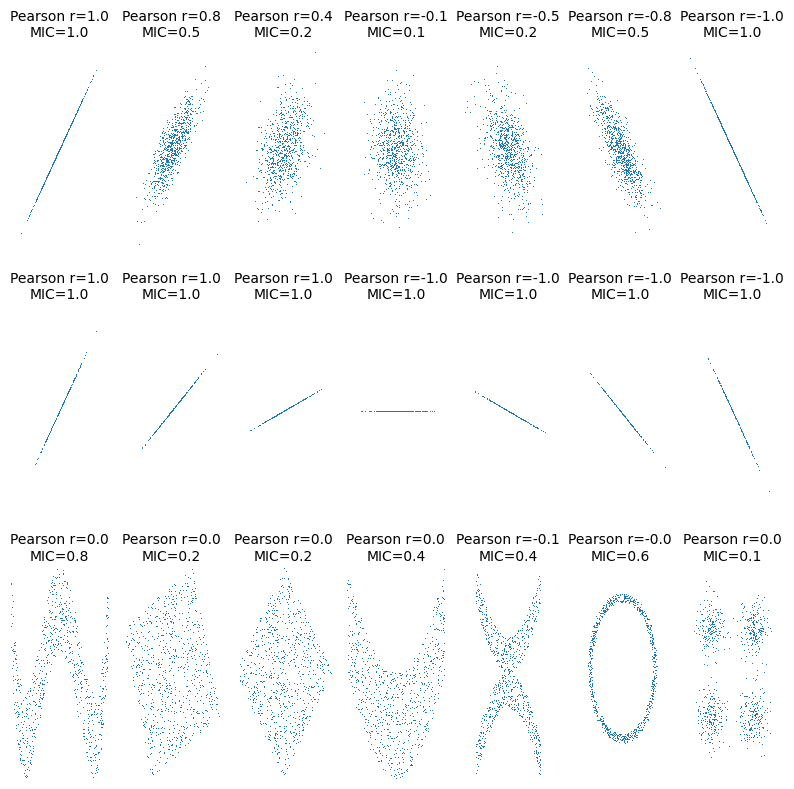

In [12]:
# further demonstration
rs = np.random.RandomState(seed=0)

def mysubplot(x, y, numRows, numCols, plotNum,
              xlim=(-4, 4), ylim=(-4, 4)):

    r = np.around(np.corrcoef(x, y)[0, 1], 1)
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x, y)
    mic = np.around(mine.mic(), 1)
    ax = plt.subplot(numRows, numCols, plotNum,
                     xlim=xlim, ylim=ylim)
    ax.set_title('Pearson r=%.1f\nMIC=%.1f' % (r, mic),fontsize=10)
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.plot(x, y, ',')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def rotation(xy, t):
    return np.dot(xy, [[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

def mvnormal(n=1000):
    cors = [1.0, 0.8, 0.4, 0.0, -0.4, -0.8, -1.0]
    for i, cor in enumerate(cors):
        cov = [[1, cor],[cor, 1]]
        xy = rs.multivariate_normal([0, 0], cov, n)
        mysubplot(xy[:, 0], xy[:, 1], 3, 7, i+1)

def rotnormal(n=1000):
    ts = [0, np.pi/12, np.pi/6, np.pi/4, np.pi/2-np.pi/6,
          np.pi/2-np.pi/12, np.pi/2]
    cov = [[1, 1],[1, 1]]
    xy = rs.multivariate_normal([0, 0], cov, n)
    for i, t in enumerate(ts):
        xy_r = rotation(xy, t)
        mysubplot(xy_r[:, 0], xy_r[:, 1], 3, 7, i+8)

def others(n=1000):
    x = rs.uniform(-1, 1, n)
    y = 4*(x**2-0.5)**2 + rs.uniform(-1, 1, n)/3
    mysubplot(x, y, 3, 7, 15, (-1, 1), (-1/3, 1+1/3))

    y = rs.uniform(-1, 1, n)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2+np.sqrt(2)) / np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 16, (-lim, lim), (-lim, lim))

    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 17, (-lim, lim), (-lim, lim))

    y = 2*x**2 + rs.uniform(-1, 1, n)
    mysubplot(x, y, 3, 7, 18, (-1, 1), (-1, 3))

    y = (x**2 + rs.uniform(0, 0.5, n)) * \
        np.array([-1, 1])[rs.random_integers(0, 1, size=n)]
    mysubplot(x, y, 3, 7, 19, (-1.5, 1.5), (-1.5, 1.5))

    y = np.cos(x * np.pi) + rs.uniform(0, 1/8, n)
    x = np.sin(x * np.pi) + rs.uniform(0, 1/8, n)
    mysubplot(x, y, 3, 7, 20, (-1.5, 1.5), (-1.5, 1.5))

    xy1 = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], int(n/4))
    xy2 = np.random.multivariate_normal([-3, 3], [[1, 0], [0, 1]], int(n/4))
    xy3 = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], int(n/4))
    xy4 = np.random.multivariate_normal([3, -3], [[1, 0], [0, 1]], int(n/4))
    xy = np.concatenate((xy1, xy2, xy3, xy4), axis=0)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 21, (-7, 7), (-7, 7))

plt.figure(facecolor='white', figsize=(8, 8))
mvnormal(n=800)
rotnormal(n=200)
others(n=800)
plt.tight_layout()
plt.show()

## Epilogue
As with $R^2$, MIC / TIC provide a quantitative metric to identify dependent features for inclusion (correlated with respone) or exclusion (correlated with other features). However, a data scientist still needs to (often) subjectively choose thresholds. A complete method to automate this procedure *a la* a statistical hypothesis test would be idea.

The article <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5893960/">A Practical Tool for Maximal Information Coefficient Analysis</a> details a "comprehensive and effective pipeline that combines TICe and MICe into a multistep procedure that allows the identification of relationships of various degrees of complexity", and has a companion python package named <a href="https://github.com/minepy/mictools">mictools</a> (`pip install mictools`). I have only cursorily reviewed this, but will be further investigating the paper and package.